# GPT - (Generative Pre-trained Transformer)

In [1]:
import numpy as np
import json
import re
import string
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

## Parameters

In [2]:
VOCAB_SIZE = 10000
MAX_LEN = 80
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 2
FEED_FORWARD_DIM = 256
VALIDATION_SPLIT = 0.2
SEED = 42
BATCH_SIZE = 32
EPOCHS = 5

## Load the data

In [3]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/zynicide/wine-reviews")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sayandafadar
Your Kaggle Key: ··········


100%|██████████| 50.9M/50.9M [00:00<00:00, 144MB/s]


In [5]:
# Load the full dataset
with open("/content/wine-reviews/winemag-data-130k-v2.json") as json_data:
  wine_data = json.load(json_data)

In [6]:
wine_data[10]

{'points': '87',
 'title': 'Kirkland Signature 2011 Mountain Cuvée Cabernet Sauvignon (Napa Valley)',
 'description': 'Soft, supple plum envelopes an oaky structure in this Cabernet, supported by 15% Merlot. Coffee and chocolate complete the picture, finishing strong at the end, resulting in a value-priced wine of attractive flavor and immediate accessibility.',
 'taster_name': 'Virginie Boone',
 'taster_twitter_handle': '@vboone',
 'price': 19,
 'designation': 'Mountain Cuvée',
 'variety': 'Cabernet Sauvignon',
 'region_1': 'Napa Valley',
 'region_2': 'Napa',
 'province': 'California',
 'country': 'US',
 'winery': 'Kirkland Signature'}

In [7]:
# Filter the dataset
filtered_data = [
    "wine review : "
    + x["country"]
    + " : "
    + x["province"]
    + " : "
    + x["variety"]
    + " : "
    + x["description"]
    for x in wine_data
    if x["country"] is not None
    and x["province"] is not None
    and x["variety"] is not None
    and x["description"] is not None
]

In [8]:
# Count the recipes
n_wines = len(filtered_data)
print(f"{n_wines} recipes loaded")

129907 recipes loaded


In [9]:
example = filtered_data[25] 
example

'wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard-designated Pinot that hails from a high-elevation site. Small in production, it offers intense, full-bodied raspberry and blackberry steeped in smoky spice and smooth texture.'

## Tokenize the data

In [10]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
  s = re.sub(f"([{string.punctuation}, '\n'])", r" \1 ", s)
  s = re.sub(" +", " ", s)
  return s

text_data = [pad_punctuation(x) for x in filtered_data]

In [11]:
# Display an example of a recipe
example_data = text_data[25]
example_data

'wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard - designated Pinot that hails from a high - elevation site . Small in production , it offers intense , full - bodied raspberry and blackberry steeped in smoky spice and smooth texture . '

In [12]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

In [13]:
# Create a vectorization layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

In [14]:
# Adapt the layer to the trainging set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [15]:
# Display some token:word mappings
for i, word in enumerate(vocab[:10]):
  print(f"{i}: {word}")

0: 
1: [UNK]
2: :
3: ,
4: .
5: and
6: the
7: wine
8: a
9: of


In [16]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(example_data)
print(example_tokenised.numpy())
print(len(example_tokenised.numpy()))

[   7   10    2   20    2   29    2   43   62    2   55    5  243 4145
  453  634   26    9  497  499  667   17   12  142   14 2214   43   25
 2484   32    8  223   14 2213  948    4  594   17  987    3   15   75
  237    3   64   14   82   97    5   74 2633   17  198   49    5  125
   77    4    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
81


## Create the Training Set

In [17]:
# Create the training set of recipes and the same text shifted by one word
def prepare_inputs(text):
  text = tf.expand_dims(text, -1)
  tokenized_sentences = vectorize_layer(text)
  x = tokenized_sentences[:, :-1]
  y = tokenized_sentences[:, 1:]
  return x, y

train_ds = text_ds.map(prepare_inputs)

In [18]:
example_input_output = train_ds.take(1).get_single_element()

In [19]:
# Example Input
example_input_output[0][0]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([   7,   10,    2,   20,    2,  150,    2,   43,   62,    2,    8,
       2511,    3,  273,  884, 1441, 4487, 1070,   12,    7,    4,   79,
         18,   21,  278,    5,  887,   22,    3,  553,  420,    3,    5,
        953,  127,   13,   17,  160,    4,   33,   25,  769,  884,  141,
        720,  366,   84,    6,   31,    4,  455, 2384, 1086, 1580,   11,
       1343, 1705,    4,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

In [20]:
# Example Output (shifted by one token)
example_input_output[1][0]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([  10,    2,   20,    2,  150,    2,   43,   62,    2,    8, 2511,
          3,  273,  884, 1441, 4487, 1070,   12,    7,    4,   79,   18,
         21,  278,    5,  887,   22,    3,  553,  420,    3,    5,  953,
        127,   13,   17,  160,    4,   33,   25,  769,  884,  141,  720,
        366,   84,    6,   31,    4,  455, 2384, 1086, 1580,   11, 1343,
       1705,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

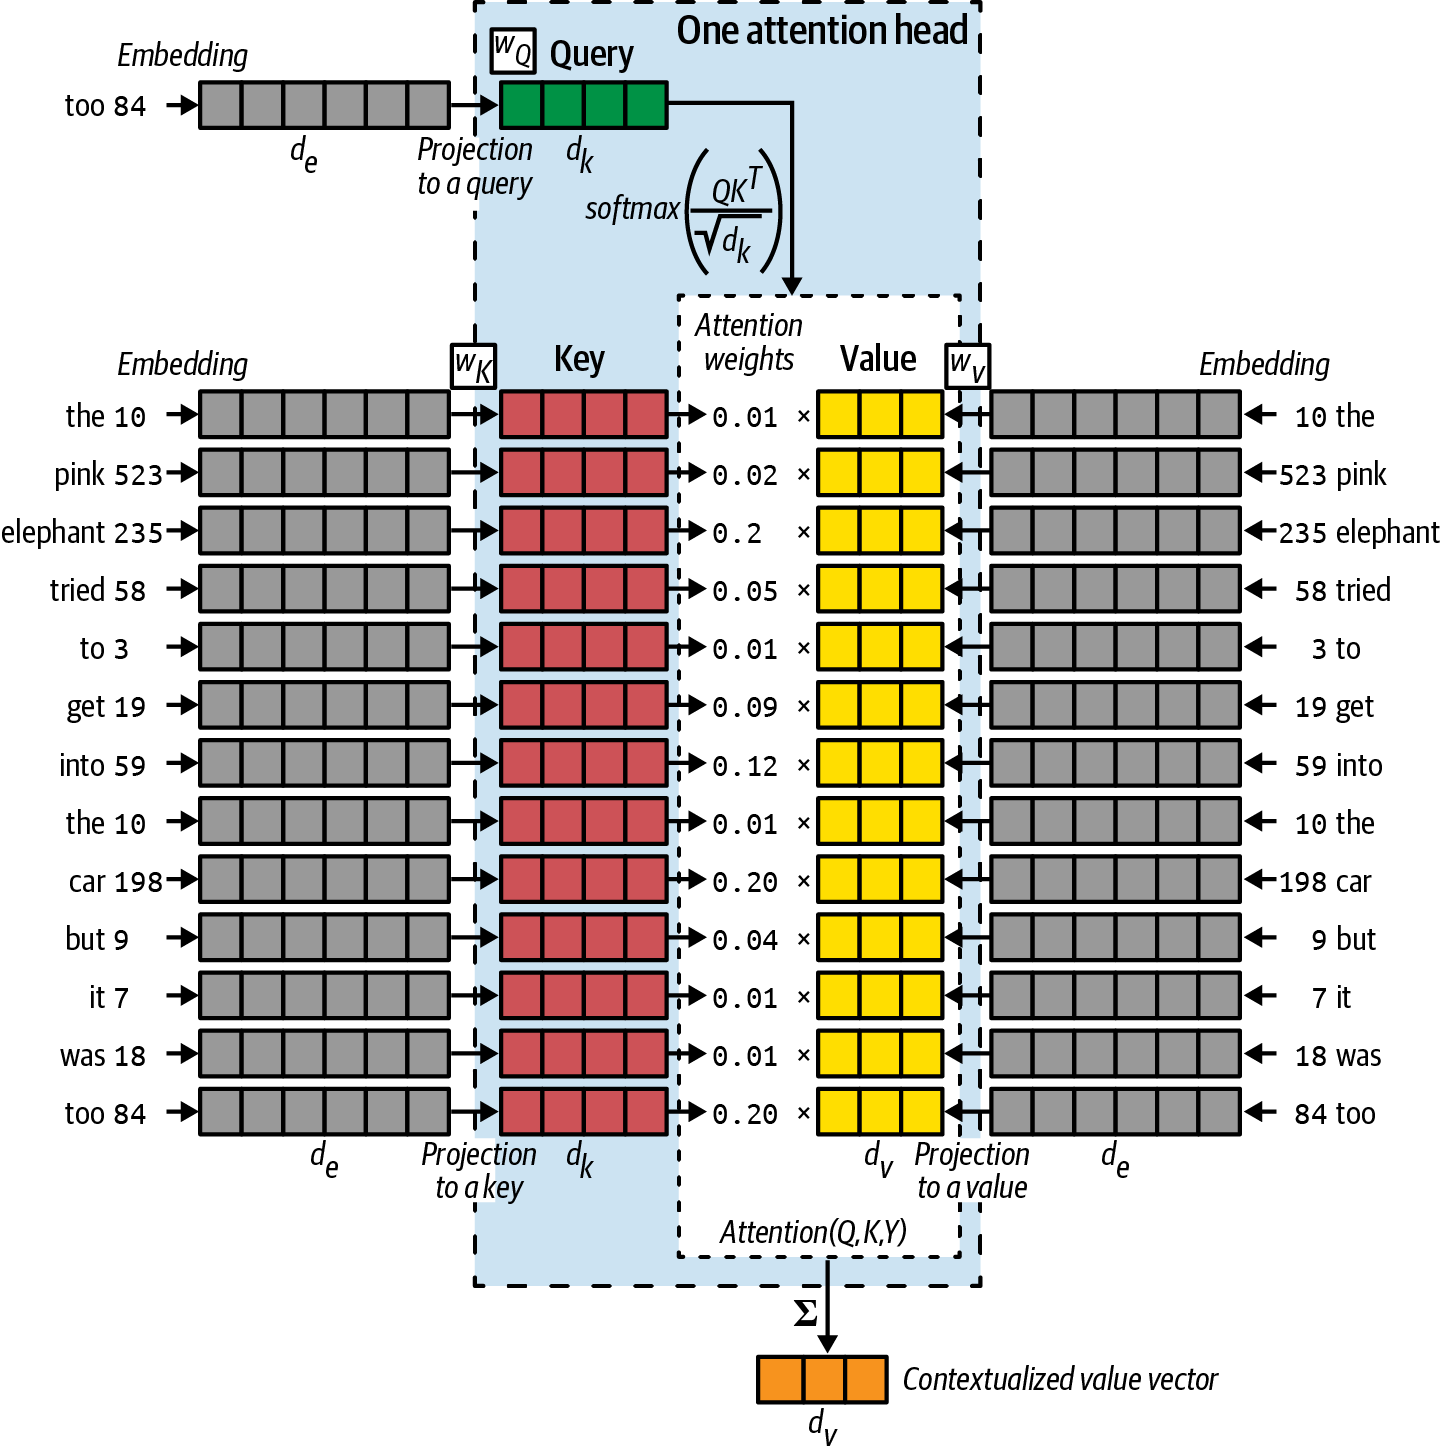

## Creating the Causal Mask 

In [21]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
  i = tf.range(n_dest)[:, None]
  j = tf.range(n_src)
  m = i >= j - n_src + n_dest
  mask = tf.cast(m, dtype) 
  mask = tf.reshape(mask, [1, n_dest, n_src]) 
  mult = tf.concat(
      [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
  )
  return tf.tile(mask, mult)

np.transpose(causal_attention_mask(1, 10, 10, dtype = tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## Creating the Transformer Block

In [22]:
class TransformerBlock(layers.Layer):
  def __init__(self, num_heads, key_dim, embed_dim, ff_dim, dropout_rate=0.1):
    super(TransformerBlock, self).__init__()
    self.num_heads = num_heads
    self.key_dim = key_dim
    self.embed_dim = embed_dim
    self.ff_dim = ff_dim
    self.dropout_rate = dropout_rate
    self.attn = layers.MultiHeadAttention(
        num_heads, key_dim, output_shape = embed_dim
    )
    self.dropout_1 = layers.Dropout(self.dropout_rate)
    self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
    self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
    self.ffn_2 = layers.Dense(self.embed_dim)
    self.dropout_2 = layers.Dropout(self.dropout_rate)
    self.ln_2 = layers.LayerNormalization(epsilon=1e-6) 

  def call(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size = input_shape[0]
    seq_len = input_shape[1]
    causal_mask = causal_attention_mask(
        batch_size, seq_len, seq_len, tf.bool
    )
    attention_output, attention_scores = self.attn(
        inputs, # Source
        inputs, # Target
        attention_mask=causal_mask,
        return_attention_scores=True
    )
    attention_output = self.dropout_1(attention_output)
    out1 = self.ln_1(inputs + attention_output)
    ffn_1 = self.ffn_1(out1)
    ffn_2 = self.ffn_2(ffn_1) 
    ffn_output = self.dropout_2(ffn_2)
    return (self.ln_2(out1 + ffn_output), attention_scores)

## Creating the `TokenAndPositionalEmbedding` layer

In [23]:
class TokenAndPositionalEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionalEmbedding, self).__init__()
    self.maxlen = maxlen
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    self.token_emb = layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1) 
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return x + positions

## A GPT model

In [24]:
inputs = layers.Input(shape=(None,), dtype=tf.int32)
x = TokenAndPositionalEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM
)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
gpt = models.Model(inputs=inputs, outputs=[outputs, attention_scores])
gpt.compile("adam", loss=[losses.SparseCategoricalCrossentropy(), None])

In [25]:
gpt.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_positional_embedd  (None, None, 256)        2580480   
 ing (TokenAndPositionalEmbe                                     
 dding)                                                          
                                                                 
 transformer_block (Transfor  ((None, None, 256),      658688    
 merBlock)                    (None, 2, None, None))             
                                                                 
 dense_2 (Dense)             (None, None, 10000)       2570000   
                                                                 
Total params: 5,809,168
Trainable params: 5,809,168
Non-trainable params: 0
___________________________________________________

In [26]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:
            x = np.array([start_tokens])
            y, att = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], temperature)
            info.append(
                {
                    "prompt": start_prompt,
                    "word_probs": probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("wine review", max_tokens=80, temperature=1.0)

In [27]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [28]:
gpt.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, tensorboard_callback, text_generator],
)

Epoch 1/5
4059/4060 [============================>.] - ETA: 0s - loss: 2.2505 - dense_2_loss: 2.2505
generated text:
wine review : us : california : syrah : thickly extracted in blackberries and dark fruit , this is nowhere near - perfect for a pretty wine . but it ' s dry , able to understand that this is one of the evolution here ' s finest and one smooth . while the pepper comes from stagecoach vineyard as far as [UNK] in every blind . for aging , and it ' s that oregon old , adding at

4060/4060 [==============================] - 205s 48ms/step - loss: 2.2504 - dense_2_loss: 2.2504
Epoch 2/5
4059/4060 [============================>.] - ETA: 0s - loss: 1.9579 - dense_2_loss: 1.9579
generated text:
wine review : france : burgundy : chardonnay : with the mineral texture hinting at the herbaceous aromas with juice and acidity , this is rather dominant . the wine that is laced with wood , spice and hints at give it 2–3 time to [UNK] . 

4060/4060 [==============================] - 115s 